In [1]:
import sys
import os
current_dir = os.path.dirname(os.curdir)
parent_dir = os.path.abspath(os.path.join(current_dir, "../.."))
sys.path.append(parent_dir)
import torch
import system.units as units
import system.topology as topology
import system.box as box
import forces.twobody as twobody
import system.system as sys
from integrators.NVE import NVE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import freud
import numpy as np
from tqdm import trange
from utils import *
device = "cuda"


╔═══════════════════════════════════════════════════╗
║                                                   ║
║  ██████╗   ██████╗    ██╗      ██████╗   ██╗  ██╗ ║
║ ██╔════╝  ██╔══██╗   ██╔██╗    ██╔══██╗  ██║ ██╔╝ ║
║ ╚█████╗   ██████╔╝  ██╔╝╚██╗   ██████╔╝  █████╔╝  ║
║  ╚═══██╗  ██╔═══╝  ██╔╝  ╚██╗  ██╔══██╗  ██╔═██╗  ║
║ ██████╔╝  ██║     ██╔╝    ╚██╗ ██║  ██║  ██║ ╚██╗ ║
║ ╚═════╝   ╚═╝     ╚═╝      ╚═╝ ╚═╝  ╚═╝  ╚═╝  ╚═╝ ║
║                                                   ║
║     Statistical Physics Autodiff Research Kit     ║
╚═══════════════════════════════════════════════════╝

          V(r)           ψ, φ              q
           │               │               │
           ○               ○               ○
         ╱ | ╲           ╱ | ╲           ╱ | ╲
        ○  ○  ○         ○  ○  ○         ○  ○  ○
         ╲ | ╱           ╲ | ╱           ╲ | ╱
           ○               ○               ○
           │               │               │
          g(r)             F         

In [2]:
arity_table = (
    ["mie"],
    [2]
)
top = topology.Topology(arity_table)
print(top)
for i in range(15**3):
    for j in range(i):
        top.add(2,"mie",(i,j))

b = box.Box([15.872443025792107,15.872443025792107,15.872443025792107],["p","p","p"])
print(b)

u = units.UnitSystem()
print(u)

mie = twobody.Mie(n = 12, sigma = 1, epsilon = 1,label = "mie")

B = 64
pos = make_sc_lattice(a=1.05, nx=15, ny=15, nz=15, batch=B)  # (4, 20**3, 3)
N = len(pos[0])
pos = pos - pos.mean(dim=1, keepdim=True) + torch.tensor([[b.Lx, b.Ly, b.Lz]], device=device) / 2
mom = 0.59*torch.randn(B,N,3,device=device)
mass = torch.ones(N,device=device)
mass = mass.unsqueeze(dim=0).expand(B,N) * torch.linspace(1,5,B,device=device).unsqueeze(dim=1)

energy_dict = {"mie":mie}
S = sys.System(pos, mom, mass, top, b, energy_dict, u)
S.compile_force_fn()
print(S)

integrator = NVE(0.01)
print(integrator)

print(f"Density {(len(pos[0])/b.volume).item()}")

Topology(mie (arity 2))
Box(15.8724p, 15.8724p, 15.8724p)
UnitSystem(L=1 m/uL, E=1 J/uE, M=1 kg/um, kB=1 uE/K, Q=1 e/uQ)
System(Batches: 64, Atoms: 3375, Interactions: 1, Box: Box(15.8724p, 15.8724p, 15.8724p), Units: UnitSystem(L=1 m/uL, E=1 J/uE, M=1 kg/um, kB=1 uE/K, Q=1 e/uQ))
NVE(dt=0.01)
Density 0.8440000414848328


In [3]:
steps = 500
skip = 50
bins=500
temperature = torch.empty((steps,B),device=device)
rdfs = torch.empty((int(steps/skip),B,bins),device=device)
rmin=0.5
rmax = 7.5
box_freud = freud.box.Box.from_box(b.edges.detach().cpu().numpy())

# EQUILIBRATE
with torch.no_grad():
    for i in trange(500, desc="Equilibrating System"):
        integrator.step(S)
        
# PRODUCTION
with torch.no_grad():
    for i in trange(steps, desc="Running Simulation"):
        temperature[i] = S.temperature()
        
        if i % skip  == 0:
            rdf = freud.density.RDF(bins=bins, r_max=rmax, r_min=rmin)
            for j in range(B): 
                rdf.compute(system=(box_freud, (S.pos[j] - b.Lx).detach().cpu()), reset=False)
                rdfs[int(i/skip),j] = torch.tensor(rdf.rdf)
        integrator.step(S)
        S.reset_cache()

Running Simulation: 100%|████████████████████████████████████████████████████████████████████████████| 500/500 [04:43<00:00,  1.77it/s]


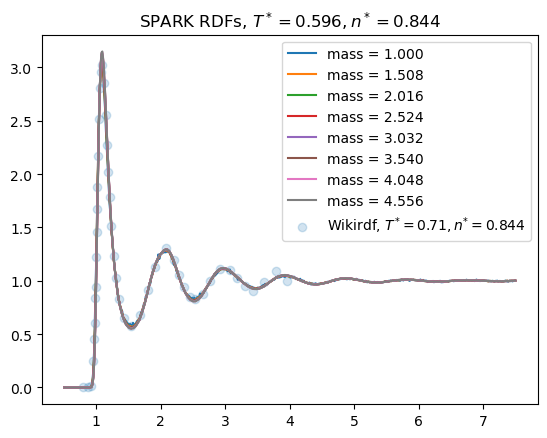

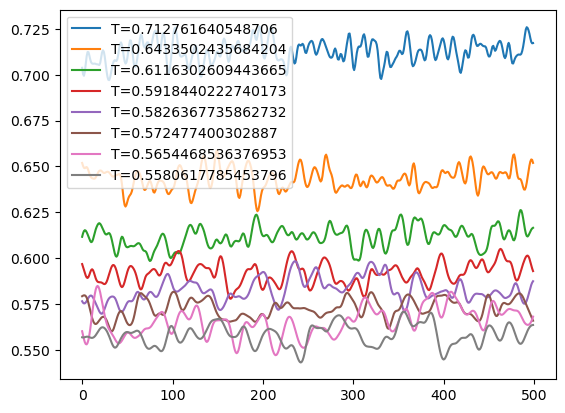

In [4]:
wikirdf = np.loadtxt("wikipedia_rdf.csv",delimiter=",")
plt.title(f"SPARK RDFs, $ T^*={(temperature.mean().item()):.3f},n^*={((len(pos[0])/b.volume).item()):.3f}$")
for j in range(B):
    if j % 8 == 0:
        plt.plot(rdf.bin_centers,rdfs[:,j].mean(dim=0).detach().cpu(),label=f"mass = {mass[j,0].item():.3f}")
plt.scatter(wikirdf.T[0],wikirdf.T[1],alpha=0.2,label=r'Wikirdf, ${ T^{*}=0.71,n^{*}=0.844}$')
plt.legend()
plt.show()

for j in range(B):
    if j % 8 == 0:
        plt.plot(temperature[:,j].detach().cpu(),label=f"T={temperature[:,j].mean().item()}")
plt.legend()
plt.show()

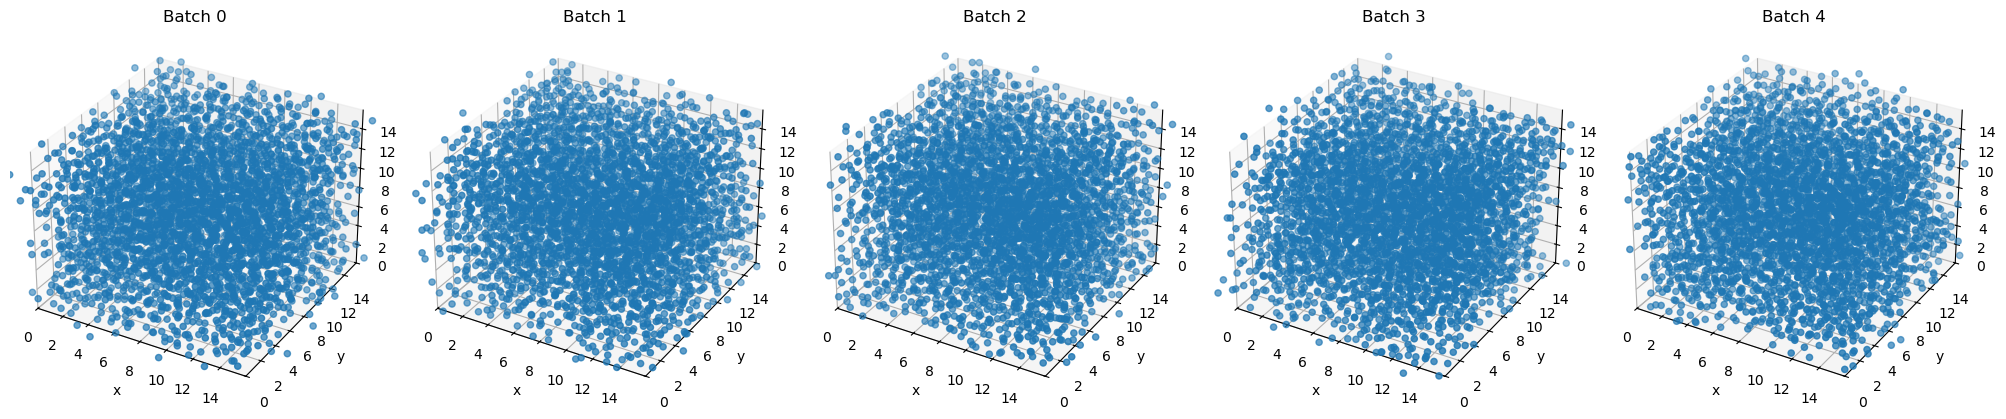

In [5]:
fig = plt.figure(figsize=(4 * pos.shape[0], 4))
for i in range(5):
    ax = fig.add_subplot(1, S.pos.shape[0], i + 1, projection='3d')
    ax.scatter(*S.pos[i].T.cpu().numpy())
    ax.set_title(f'Batch {i}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim(0,b.Lx.detach().cpu())
    ax.set_ylim(0,b.Ly.detach().cpu())
    ax.set_zlim(0,b.Lz.detach().cpu())
plt.tight_layout()
plt.show()